Image augmentation generates similar but distinct training examples after a series of random changes to the training images, thereby expanding the size of the
training set.  
**Note**: Random tweaks
of training examples allow models to less rely on certain attributes, thereby improving their generalization ability.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install d2l

In [ ]:
!pip install matplotlib==3.0.0

In [7]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

###1. Common Image Augmentation Methods  

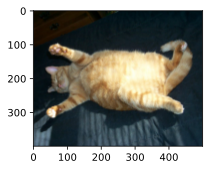

In [8]:
# An example -- 400x500 image
d2l.set_figsize()
img = d2l.Image.open('drive/MyDrive/d2l-zh/img/cat1.jpg')
d2l.plt.imshow(img)

In [9]:
# implement apply function
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### 1.1 Flipping and Cropping

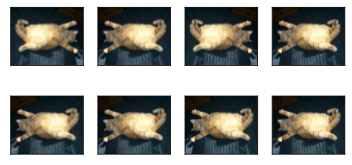

In [10]:
# horizontally flipping
apply(img, torchvision.transforms.RandomHorizontalFlip())

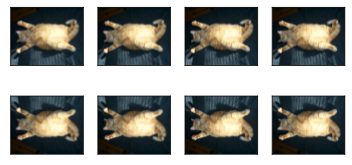

In [11]:
# vertically flipping
apply(img, torchvision.transforms.RandomVerticalFlip())

To reduce the sensitivity of a model to the target position:  
1. Use pooling layer;
2. Crop the image randomly to make objects appear in different positions in the image at different scales.

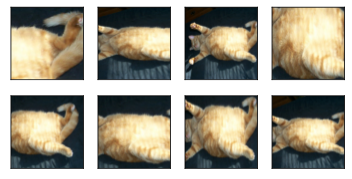

In [12]:
# cropping
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

####1.2 Changing Colors
Four aspects: brightness, contrast, saturation, and hue.

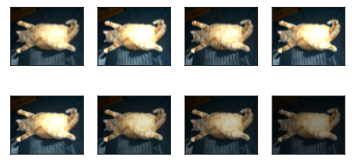

In [13]:
# brightness
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

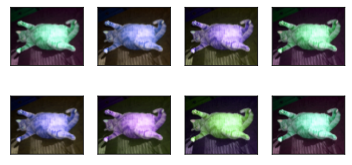

In [14]:
# hue
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

####1.3 Combining Multiple Image Augmentation Methods

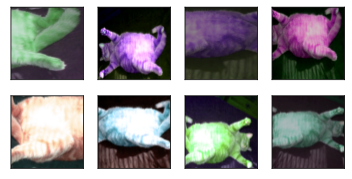

In [15]:
# use compose to combine different image augmentation
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
augs = torchvision.transforms.Compose([
                                      torchvision.transforms.RandomHorizontalFlip(),
                                      color_aug, shape_aug
])
apply(img, augs)

###2. Training with Image Augmentation

Files already downloaded and verified


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fedbf218350>,
      dtype=object)

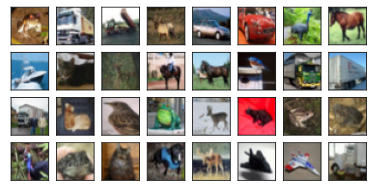

In [16]:
all_images = torchvision.datasets.CIFAR10(train=True, root='drive/MyDrive/d2l-zh/data',
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In order to obtain definitive results during prediction, we usually only apply image augmentation
to training examples, and do not use image augmentation with random operations during prediction. Here we only use the simplest random left-right flipping method. In addition, we use a
ToTensor instance to convert a minibatch of images into the format required by the deep learning framework, i.e., 32-bit floating point numbers between 0 and 1 with the shape of (batch size,
number of channels, height, width).

In [18]:
train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), 
                                             torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [19]:
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root='drive/MyDrive/d2l-zh/data', train=is_train,
                                         transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=is_train, num_workers=d2l.get_dataloader_workers())
  return dataloader

In [25]:
# Multi-GPU Training
def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

In [26]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
  legend=['train loss', 'train acc', 'test acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
  # Sum of training loss, sum of training accuracy, no. of examples,
  # no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                  (metric[0] / metric[2], metric[1] / metric[3],
                  None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
        f'{str(devices)}')

In [27]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
    
net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.177, train acc 0.939, test acc 0.819
1314.3 examples/sec on [device(type='cuda', index=0)]


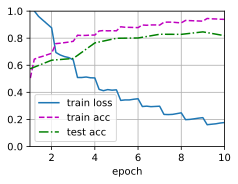

In [28]:
train_with_data_aug(train_augs, test_augs, net)

**Summary**:
1. Image augmentation generates random images based on existing training data to improve
the generalization ability of models.
2. In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations
during prediction.
3. Deep learning frameworks provide many different image augmentation methods, which can
be applied simultaneously.